# NURBS - Parabolic Mirror

Author: Matteo Taccola

This example shows how to use the NURBS geometry without passing explicitly the parameters that define the NURBS (control points, weights etc).
If a radius (and optionally a conic constant) are defined and no control points are passed the NURBS is generated as a surface approximation of the base conic.
Please note that this can be easily expanded to the fitting of every other possible surface (asphere,zernike etc.) 

In [1]:
from optiland.geometries import NurbsGeometry

In [2]:
from optiland import analysis, optic, optimization
from optiland.coordinate_system import CoordinateSystem
from optiland.materials import IdealMaterial, Material
from optiland.surfaces import Surface
import optiland.backend as be

Generate NURBS reflector approximating parabola surface

Surface parameters

In [3]:
radius = -100.0
conic = -1

Coordinate system

In [4]:
cs = CoordinateSystem(x=0, y=0, z=0, rx=0, ry=0, rz=0, reference_cs=None)

Generate geometry. if control points are passed radius and conic are ignored and the surface is built as NURBS from control points and weights.
In this case we pass a base conic profile (parabola).
The surface is generated deriving a grid of control points (in this case a 7x7 grid)

In [5]:
nurbs_geo = NurbsGeometry(
    coordinate_system=cs,
    radius = radius,
    conic=conic, 
    n_points_u = 7, 
    n_points_v = 7, 
)        

Generate surface. Both materials pre and post are air

In [6]:
material_pre = IdealMaterial(n=1.0)
material_post = IdealMaterial(n=1.0)

In [9]:
new_surface = Surface(
    geometry=nurbs_geo,
    material_pre=material_pre,
    material_post=material_post,
    is_stop=True,
)

# Change interaction model to reflective
new_surface.interaction_model.is_reflective = True

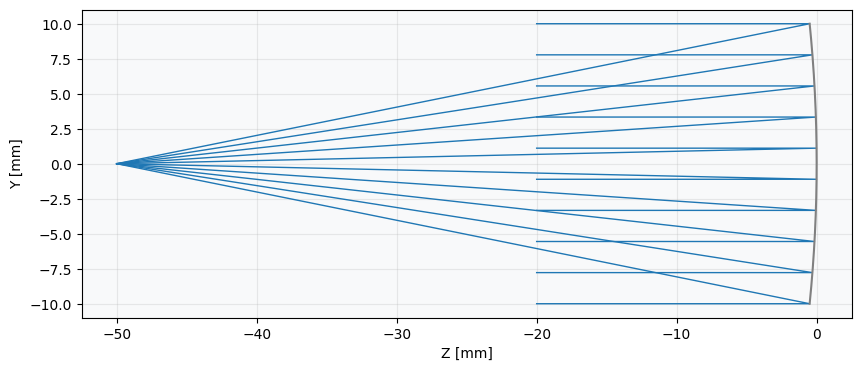

In [11]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, radius=be.inf, thickness=be.inf)
lens.add_surface(
    index=1,
    new_surface=new_surface,
    thickness=-50,
)
lens.add_surface(index=2)

EPD = 20.0  # entrance pupil diameter

# add aperture
lens.set_aperture(aperture_type="EPD", value=EPD)

# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)

# add wavelength
lens.add_wavelength(value=0.55, is_primary=True)

lens.update_paraxial()  #This is needed to assign the NURBS aperture and perform the surface fitting 

_ = lens.draw(num_rays=10)

Check that the spot is a 'point' as expected from a parabola.
Deviations from a point are linked to surface fit accuracy. 

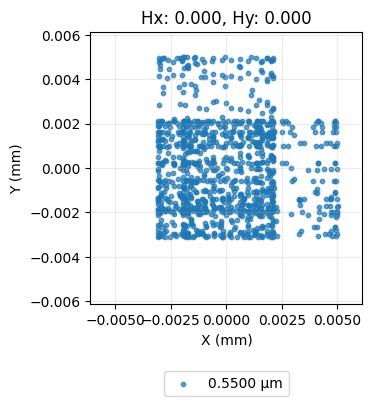

In [12]:
spot = analysis.SpotDiagram(lens,num_rings=18)
_ = spot.view() 

Let's introduce a decenter to have an off axis parabola

In [13]:
dy = 20

In [14]:
lens.surface_group.surfaces[1].geometry.cs.y = dy

The function `fit_surface` defines the NURBS parameters that fit the surface profile on a rectangular aperture with center `(x_center, ycenter)` and sides $2*norm_x$ and $2*norm_y$.
Since the decenter of the parabola is dy a new fit of the surface should be performed with `y_center = -dy`

In [15]:
lens.surface_group.surfaces[1].geometry.y_center = -dy

Call `fit_surface` function to compute again control points and weights that approximate the parabola

In [16]:
lens.surface_group.surfaces[1].geometry.fit_surface()

Draw lens. 
Note how the NURBS surface doesn't fit the parabola in the region outside the optical aperture where the fit was not performed. 

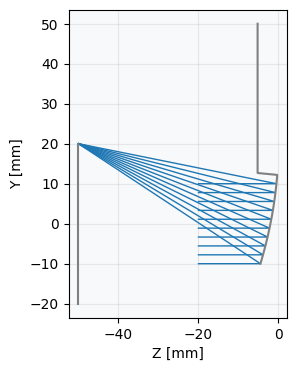

In [18]:
_ = lens.draw(num_rays=10)

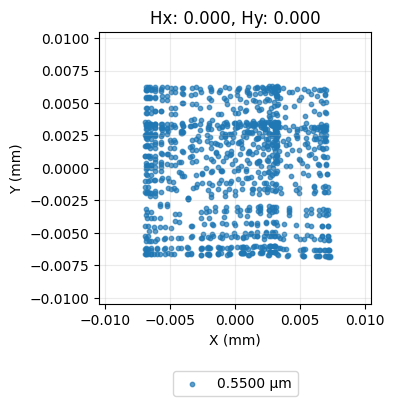

In [19]:
spot = analysis.SpotDiagram(lens,num_rings=18)
_ = spot.view() 

To verify that the surface outside the fit area is 'uncontrolled' let's increase the beam aperture and trace more rays. The rays outside the fitted area follows 'uncontrolled' reflection   

In [20]:
lens.set_aperture(aperture_type="EPD", value=2.0*EPD)

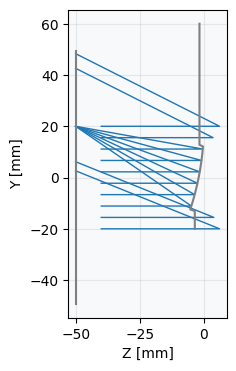

In [21]:
_ = lens.draw(num_rays=10)